# Recognition Parametrized Model (RPM): HMM-MAZE


Observations $x_t$ are MNIST renderings of digits that evolve according to Markovian transitions.  
The RPM exploits this transition structure of the environment to learn good latent features.

RMP infers the discrete-valued latent $z_t$ using a recognition network $f_\theta(.|x_t)$ (without explicit label information). The model writes:

$$   P(\mathcal{X}, \mathcal{Z}) = \prod_t \left( p_0(x_t) \frac{f_{\theta}(z_t|x_t)}{\frac1T \sum_t f_{\theta}(z_t|x_t)} p(z_t | z_{t-1})\right) \pi(z_0)$$



## Load MNIST


In [21]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils import inv_perm, RBF
from unstructured_recognition_MazeCategorical import Net, UnstructuredRecognition, permute_prediction

# Load MNIST
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
    )

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
    )


## Use HMM transition to generate image trajectories

In [22]:

# Random seeds
np.random.seed(22)
torch.manual_seed(22)

# Keep Only some digits
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5])
num_digits = len(sub_ids)

# True Transition Matrix
transition_matrix_true = RBF(sub_ids, sub_ids, 1, 1)
transition_matrix_true = transition_matrix_true / torch.sum(transition_matrix_true, dim=1, keepdim=True)

# True Initial Probabilities
initial_prob = torch.ones(num_digits) / num_digits

# T or trajectory length
trajectory_length = 10000

# Init a trajectory
trajectory = torch.zeros(trajectory_length)

# Sample initial State
pi_cur = torch.distributions.categorical.Categorical(probs=initial_prob)
di_cur = pi_cur.sample()

# Store Current Digit
trajectory[0] = di_cur

# Sample full trajectory from initial state
for t in range(trajectory_length-1):
    pi_cur.probs = transition_matrix_true[di_cur]
    di_cur = pi_cur.sample()
    trajectory[t] = di_cur


# Grasp MNIST dataset
train_images = train_data.train_data
train_labels = train_data.train_labels

# Permute MNIST
perm = torch.randperm(len(train_images))

# Size Of each image
image_size = train_images.shape[-1]

# Init the full trajectory in term of images
trajectory_image = torch.zeros(trajectory_length, image_size, image_size)

# Init a compt to assign digits different digits each time
comp = torch.zeros(num_digits)

for t in range(trajectory_length):
    # Current offset on comp
    id_tmp = comp[trajectory[t].numpy().astype(int)].numpy().astype(int)

    # Update offset
    comp[trajectory[t].numpy().astype(int)] += 1

    # Grasp images corresponding to current label
    cur_id_indices = (train_labels == trajectory[t]).nonzero()

    # Assign an image with offset if
    if id_tmp>=len(cur_id_indices):
        comp[trajectory[t].numpy().astype(int)] = 0
        id_tmp = comp[trajectory[t].numpy().astype(int)].numpy().astype(int)
        comp[trajectory[t].numpy().astype(int)] += 1

    cur_id = cur_id_indices[id_tmp]

    # Store Image
    trajectory_image[t] = train_images[cur_id]


## Plot subsection of a given trajectory

Text(0.5, 0, 'Step')

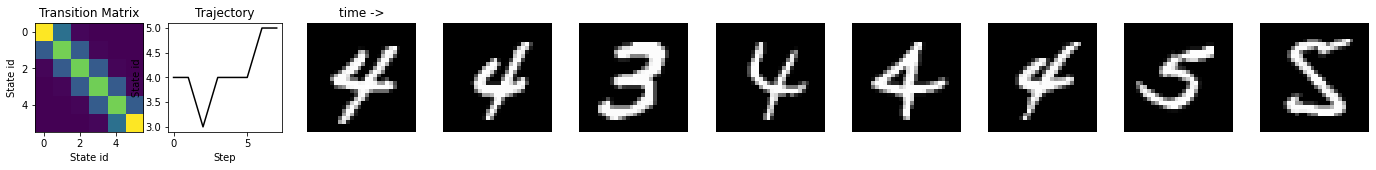

In [25]:
# Plot subsection of a given trajectory
nmax = np.floor(np.sqrt(trajectory_length))

xmax = 8
offset = 30
plt.figure(figsize=(xmax*3,1*2))
for t in range(xmax):
    plt.subplot(1, xmax + 2, t+3)
    plt.imshow(trajectory_image[t+offset], cmap='gray')
    plt.axis('off')
    #plt.title('t=' + str(t) + ' id=' + str(trajectory[t].numpy().astype(int)))
    if t == 0:
        plt.title('time ->')
        
plt.subplot(1, xmax + 2, 1)
plt.imshow(transition_matrix_true)
plt.title('Transition Matrix')
plt.xlabel('State id')
plt.ylabel('State id')


plt.subplot(1, xmax + 2, 2)
plt.plot(trajectory[offset:(offset+(xmax*1))], color='k')
plt.title('Trajectory')
plt.ylabel('State id')
plt.xlabel('Step')


# Fit

In [26]:
# Fit Parameters
fit_params = {"ite_max": 1000}

# Init Model
model = UnstructuredRecognition(num_digits, trajectory_image, fit_params=fit_params)

# Fit model
loss_tot = model.fit(trajectory_image)

Iteration :1/1000 Loss 3687.4043
Iteration :2/1000 Loss 2659.1719
Iteration :3/1000 Loss 1198.374
Iteration :4/1000 Loss 570.58984
Iteration :5/1000 Loss 73.6543
Iteration :6/1000 Loss -220.50586
Iteration :7/1000 Loss -317.1328
Iteration :8/1000 Loss -349.80078
Iteration :9/1000 Loss -374.70703
Iteration :10/1000 Loss -391.98242
Iteration :11/1000 Loss -413.9336
Iteration :12/1000 Loss -461.17188
Iteration :13/1000 Loss -534.06445
Iteration :14/1000 Loss -622.52344
Iteration :15/1000 Loss -717.5918
Iteration :16/1000 Loss -816.34375
Iteration :17/1000 Loss -919.2285
Iteration :18/1000 Loss -1027.748
Iteration :19/1000 Loss -1143.6992
Iteration :20/1000 Loss -1267.0469
Iteration :21/1000 Loss -1397.543
Iteration :22/1000 Loss -1534.5146
Iteration :23/1000 Loss -1675.9834
Iteration :24/1000 Loss -1819.9883
Iteration :25/1000 Loss -1964.7715
Iteration :26/1000 Loss -2105.9043
Iteration :27/1000 Loss -2238.9512
Iteration :28/1000 Loss -2360.6992
Iteration :29/1000 Loss -2470.1602
Iteratio

Iteration :235/1000 Loss -6619.379
Iteration :236/1000 Loss -6623.9727
Iteration :237/1000 Loss -6628.592
Iteration :238/1000 Loss -6633.1504
Iteration :239/1000 Loss -6637.713
Iteration :240/1000 Loss -6642.249
Iteration :241/1000 Loss -6646.7666
Iteration :242/1000 Loss -6651.2754
Iteration :243/1000 Loss -6655.7637
Iteration :244/1000 Loss -6660.247
Iteration :245/1000 Loss -6664.7393
Iteration :246/1000 Loss -6669.202
Iteration :247/1000 Loss -6673.658
Iteration :248/1000 Loss -6678.1084
Iteration :249/1000 Loss -6682.5615
Iteration :250/1000 Loss -6687.0254
Iteration :251/1000 Loss -6691.451
Iteration :252/1000 Loss -6695.8867
Iteration :253/1000 Loss -6700.3076
Iteration :254/1000 Loss -6704.711
Iteration :255/1000 Loss -6709.0527
Iteration :256/1000 Loss -6713.4766
Iteration :257/1000 Loss -6717.8516
Iteration :258/1000 Loss -6722.1914
Iteration :259/1000 Loss -6726.551
Iteration :260/1000 Loss -6730.874
Iteration :261/1000 Loss -6735.1816
Iteration :262/1000 Loss -6739.4736
Ite

Iteration :467/1000 Loss -7404.825
Iteration :468/1000 Loss -7407.494
Iteration :469/1000 Loss -7410.125
Iteration :470/1000 Loss -7412.7686
Iteration :471/1000 Loss -7415.4062
Iteration :472/1000 Loss -7418.0225
Iteration :473/1000 Loss -7420.6777
Iteration :474/1000 Loss -7423.26
Iteration :475/1000 Loss -7425.8643
Iteration :476/1000 Loss -7428.4443
Iteration :477/1000 Loss -7431.052
Iteration :478/1000 Loss -7433.6396
Iteration :479/1000 Loss -7436.198
Iteration :480/1000 Loss -7438.74
Iteration :481/1000 Loss -7441.3564
Iteration :482/1000 Loss -7443.881
Iteration :483/1000 Loss -7446.414
Iteration :484/1000 Loss -7448.954
Iteration :485/1000 Loss -7451.492
Iteration :486/1000 Loss -7454.0215
Iteration :487/1000 Loss -7456.5
Iteration :488/1000 Loss -7459.0557
Iteration :489/1000 Loss -7461.5664
Iteration :490/1000 Loss -7464.0645
Iteration :491/1000 Loss -7466.535
Iteration :492/1000 Loss -7469.0576
Iteration :493/1000 Loss -7471.543
Iteration :494/1000 Loss -7474.044
Iteration :

Iteration :699/1000 Loss -7944.164
Iteration :700/1000 Loss -7946.2627
Iteration :701/1000 Loss -7948.3643
Iteration :702/1000 Loss -7950.458
Iteration :703/1000 Loss -7952.545
Iteration :704/1000 Loss -7954.6406
Iteration :705/1000 Loss -7956.74
Iteration :706/1000 Loss -7958.8506
Iteration :707/1000 Loss -7960.913
Iteration :708/1000 Loss -7962.993
Iteration :709/1000 Loss -7965.0957
Iteration :710/1000 Loss -7967.1777
Iteration :711/1000 Loss -7969.2607
Iteration :712/1000 Loss -7971.385
Iteration :713/1000 Loss -7973.467
Iteration :714/1000 Loss -7975.5605
Iteration :715/1000 Loss -7977.662
Iteration :716/1000 Loss -7979.751
Iteration :717/1000 Loss -7981.9004
Iteration :718/1000 Loss -7983.96
Iteration :719/1000 Loss -7986.0635
Iteration :720/1000 Loss -7988.16
Iteration :721/1000 Loss -7990.2734
Iteration :722/1000 Loss -7992.367
Iteration :723/1000 Loss -7994.492
Iteration :724/1000 Loss -7996.6133
Iteration :725/1000 Loss -7998.75
Iteration :726/1000 Loss -8000.877
Iteration :7

Iteration :932/1000 Loss -8410.419
Iteration :933/1000 Loss -8412.037
Iteration :934/1000 Loss -8413.62
Iteration :935/1000 Loss -8415.21
Iteration :936/1000 Loss -8416.784
Iteration :937/1000 Loss -8418.359
Iteration :938/1000 Loss -8419.926
Iteration :939/1000 Loss -8421.48
Iteration :940/1000 Loss -8423.027
Iteration :941/1000 Loss -8424.571
Iteration :942/1000 Loss -8426.1045
Iteration :943/1000 Loss -8427.638
Iteration :944/1000 Loss -8429.149
Iteration :945/1000 Loss -8430.646
Iteration :946/1000 Loss -8432.154
Iteration :947/1000 Loss -8433.654
Iteration :948/1000 Loss -8435.154
Iteration :949/1000 Loss -8436.657
Iteration :950/1000 Loss -8438.151
Iteration :951/1000 Loss -8439.696
Iteration :952/1000 Loss -8441.134
Iteration :953/1000 Loss -8442.648
Iteration :954/1000 Loss -8444.171
Iteration :955/1000 Loss -8445.683
Iteration :956/1000 Loss -8447.25
Iteration :957/1000 Loss -8448.8125
Iteration :958/1000 Loss -8450.406
Iteration :959/1000 Loss -8452.065
Iteration :960/1000 Lo

## Permute state to match digit identity

In [27]:

# Model fits
latent_marginals, _ = model.latent
transition_matrix = model.transition_matrix

# Get variational-MAP trajectory
most_likely_trajectory = torch.argmax(latent_marginals, dim=1)

# Get Best State Permutation
perm = permute_prediction(most_likely_trajectory, trajectory, sub_ids)


# Permute Trajectory
most_likely_trajectory = perm[most_likely_trajectory]

# Permute Transition Matrix
transition_matrix_perm = transition_matrix[inv_perm(perm)][:,inv_perm(perm)]
#transition_matrix_perm = transition_matrix[perm][:,perm]



## Plot results

tensor(0.9788)


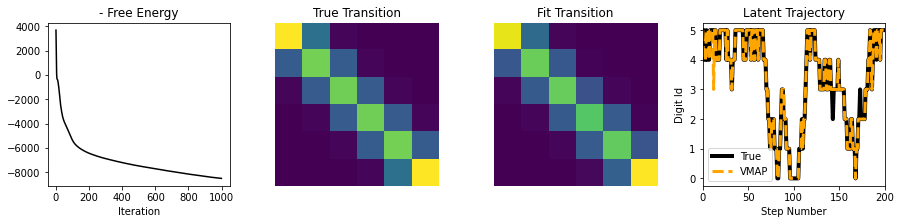

In [28]:
plt.figure(figsize=(15, 3))

# Loss
plt.subplot(1, 4, 1)
plt.plot(loss_tot, color='k')
plt.xlabel('Iteration')
plt.title('- Free Energy')

# Transition True
plt.subplot(1, 4, 2)
plt.imshow(transition_matrix_true)
plt.title('True Transition')
plt.axis('off')

# Transition Fit
plt.subplot(1, 4, 3)
plt.title('Fit Transition')
plt.imshow(transition_matrix_perm.detach().numpy())
plt.axis('off')

# True and Fit Trajectories
plt.subplot(1, 4, 4)
plt.plot(trajectory, label='True', color='k', linewidth=4)
plt.plot(most_likely_trajectory, label='VMAP', color='orange', linestyle='dashed', linewidth=3)
plt.xlim([0, 200])
plt.title('Latent Trajectory')
plt.xlabel('Step Number')
plt.ylabel('Digit Id')
plt.legend()


print(1 - torch.sum((torch.abs((trajectory-most_likely_trajectory))>0)) / len(trajectory))
